In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("proj02.ipynb")

In [3]:
from utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn-muted")
import statsmodels.api as sm

/tmp/ipykernel_82/3121195498.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-muted")


# Project 2: Mariel Boatlift
In this project, we attempt to replicate a famous paper *The Impact of the Mariel Boatlift on the Miami Labor Market* by Prof. David Card on the effects of the Mariel Boatlift on the Miami labor market. 

#### Historical Background
Amidst an economic downturn in Cuba, an increasing number of dissident Cubans were looking to leave the country and seek asylum. In response, on April 20, 1980, Cuban President Fidel Castro announced that any Cuban who wished to leave the island could do so, reversing the communist regime’s closed emigration policy. Between April and October 1980, some 1,700 boats, many arranged by Cuban exiles already in the United States, carried Cubans from the port of Mariel (the departure zone designated by the Cuban government) to Florida. 

In response, President Jimmy Carter declared temporarily a state of emergency in affected areas. On June 20, he established the Cuban-Haitian Entrant Program (CHEP), granting temporary status, access to asylum processing and community assistance for both Cubans and Haitians fleeing to the United States. Hundreds of Cubans arrived in Florida daily. The CHEP coverage window ended after the Carter administration negotiated an end to the boatlifts with the Cuban government in October 1980. ([Source](https://immigrationhistory.org/item/mariel-boatlift/))

#### Economic Impact
About half of the Mariel immigrants decided to live in Miami permanently, which resulted in "a 7\% increase in the labor force of Miami and a 20\% increase in the number of Cuban workers in Miami" ([Card (1990)](https://davidcard.berkeley.edu/papers/mariel-impact.pdf)). Aside from the unemployment rate rising from 5.0\% in April 1980 to 7.1\% in July, the actual damage to the economy was marginal and followed trends across the United States at the time. When observing data from 1979 to 1985 on the Miami labor market and comparing it with similar data from several other major cities across the United States, focusing on wages, the effects of the boatlift were marginal ([Alejandro and Leif (1989)](https://www.jstor.org/stable/2095716)). 

#### Research Approach
Since immigrants have the freedom to choose their destinations (and will naturally choose those places with strong labor markets), it is normally not enough to simply look at places with more immigrants to determine causal effects on the local labor market. However, Card argued that with the Mariel Boatlift, the arrival of immigrants had very little to do with the local labor market of that place. Here is his argument:

> The experiences of the Miami labor market in the aftermath of the Mariel Boatlift form one such \["natural"\] experiment. From May to September 1980, some 125,000 Cuban immigrants arrived in Miami on a flotilla of privately chartered boats. Their arrival was the consequence of an unlikely sequence of events culminating in Castro's declaration on April 20, 1980, that Cubans wishing to emigrate to the United States were free to leave from the port of Mariel. Fifty percent of the Mariel immigrants settled permanently in Miami. The result was a 7% increase in the labor force of Miami and a 20% increase in the number of Cuban workers in Miami. (Card, 1990:245-6)

Professor David Card received the Nobel Prize in Economics "for his empirical contributions to labour economics", including this paper among others. He delivered his [prize-winning lecture](https://youtu.be/wD48p6m8U-8?t=237) (talking about this topic, among others) on 8 December 2021.

**Reading:** You should download a copy of the original paper and read at least pages 245-251 and pages 255-257. It is available [here](http://davidcard.berkeley.edu/papers/mariel-impact.pdf).

### References

This notebook is based on another assignment by [Prof. Josh Goldstein](https://courses.demog.berkeley.edu/goldstein175).

**A Note on Grading:**  
In Project 2, the autograded questions will have hidden tests, and the text-based free response questions will be graded on correctness. 

---
## Part 1: CPS Data

First, we will load in data from the Current Population Survey (CPS). The CPS "outgoing rotation groups" that we are using for the analysis is the largest sample available for this time period. Still, once we limit ourselves to Miami and the comparison cities, the sample sizes are still small. 

In [23]:
mariel_raw = pd.read_csv("mariel-boatlift.csv")
mariel_raw.head(5)

,.id,age,smsarank,esr,ftpt79,earnhre,educ,ethrace
0,1,71,Los Angeles,Housework,Not In Labor Force,NaN,lessHS,whites
1,1,71,Los Angeles,Housework,Not In Labor Force,NaN,lessHS,whites
2,1,73,Los Angeles,Other (Includes Retired),Not In Labor Force,NaN,HS,whites
3,1,56,Los Angeles,Employed-At Work,Employed full-time,700.0,HS,whites
4,1,87,Los Angeles,Other (Includes Retired),Not In Labor Force,NaN,lessHS,whites


The columns of our table have some odd names. We provide descriptions of the variables of interest below.

| Column Name | Description |
|-----|-----|
| age | Age of individual |
| smsarank | City |
| esr | Employment status |
| ftpt79 | Full-time or part-time |
| earnhre | Nominal hourly pay in cents |
| educ | Level of education (BA, HS diploma, or < HS) |
| ethrace | Race & ethnicity |

Before moving onto the analysis of the data, there is a tiny bit of data cleaning that needs to be done. The data currently have a `.id` column, which encodes the year. However, these values range from 1 to 7, so to get the actual years, we need to add 1978 to each.

**Question 1.1:** Add 1978 to each value in the `.id` column of `mariel_raw`. Create a new table `mariel` with the same columns as `mariel_raw` but with a `year` column and no `.id` column.

The resulting `mariel` dataframe should look like the following:

| age | smsarank | esr | ftpt79 | earnhre | educ | ethrace | year |
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 71 | Los Angeles | Housework | Not In Labor Force | NaN | lessHS | whites | 1979 |
|  |  |  |  |  |  |  | ... (rows omitted) |

In [24]:
mariel = mariel_raw.copy()
year = mariel['.id']+1978
mariel = mariel.drop(columns = '.id')
mariel['year'] = year
mariel.head(5)

,age,smsarank,esr,ftpt79,earnhre,educ,ethrace,year
0,71,Los Angeles,Housework,Not In Labor Force,NaN,lessHS,whites,1979
1,71,Los Angeles,Housework,Not In Labor Force,NaN,lessHS,whites,1979
2,73,Los Angeles,Other (Includes Retired),Not In Labor Force,NaN,HS,whites,1979
3,56,Los Angeles,Employed-At Work,Employed full-time,700.0,HS,whites,1979
4,87,Los Angeles,Other (Includes Retired),Not In Labor Force,NaN,lessHS,whites,1979


In [25]:
grader.check("q1_1")

q1_1 results: All test cases passed!

As we are focusing on certain racial groups in this project, we can remove the rows of `mariel` that are not in the set of ethnicities that we are concerned with.

**Question 1.2:** Remove the rows of `mariel` where the `ethrace` variable is `"others"`.

In [26]:
mariel = mariel[mariel['ethrace'] != 'others']
mariel.head(5)

,age,smsarank,esr,ftpt79,earnhre,educ,ethrace,year
0,71,Los Angeles,Housework,Not In Labor Force,NaN,lessHS,whites,1979
1,71,Los Angeles,Housework,Not In Labor Force,NaN,lessHS,whites,1979
2,73,Los Angeles,Other (Includes Retired),Not In Labor Force,NaN,HS,whites,1979
3,56,Los Angeles,Employed-At Work,Employed full-time,700.0,HS,whites,1979
4,87,Los Angeles,Other (Includes Retired),Not In Labor Force,NaN,lessHS,whites,1979


In [27]:
grader.check("q1_2")

q1_2 results: All test cases passed!

**Question 1.3:** What categories are there in the `ethrace` variable (now)?

1. White and Black
2. White and Black and Cuban
3. White, Black, Cuban, and Hispanic
4. Cuban, Hispanic, non-Hispanic

Assign the number corresponding to your answer to `q1_3` below.

In [28]:
q1_3 = 3

In [29]:
grader.check("q1_3")

q1_3 results: All test cases passed!

**Question 1.4:** What are the units of the `earnhre` variable? Read the relevant CPS data [documentation](https://data.nber.org/morg/docs/cpsx.pdf).   

1. Cents per hour
2. Dollars per hour
3. Cents per day
4. Dollars per day
5. Cents per week
6. Dollars per week

Assign the number corresponding to your answer to `q1_4` below.

In [30]:
q1_4 = 1

In [31]:
grader.check("q1_4")

q1_4 results: All test cases passed!

**Question 1.5:** Which cities can make up the ideal comparison group in this study?

1. All U.S. cities except Miami
2. All Florida cities except Miami
3. Cities nearby that are subject to the same macroeconomic influences as Miami but didn't receive many Cuban immigrants.
4. Cities nearby that are subject to the same macroeconomic influences as Miami but received many other immigrants.

Assign the number corresponding to your answer to `q1_5` below.

In [32]:
q1_5 = 1

In [33]:
grader.check("q1_5")

q1_5 results: All test cases passed!

---
## Part 2: Unemployment 

We're going to begin by trying to replicate Card's results for unemployment in his Table 4. (We'll do wages in Table 3 later).

In the cell below, we define a function `get_ue` that takes in an array/series values from the `esr` column and returns the proportion of people who are unemployed (the unemployment rate).

In [34]:
def get_ue(esr):
    unemployed_looking = sum(esr == "Unemployed-Looking")
    others = sum(np.isin(esr, np.array(["Unemployed-Looking",  "Employed-At Work", "Employed-Absent"])))
    return unemployed_looking / others

When considering the effect on the unemployment rate of the boatlift, we want to first separate Miami from the comparison cities and select for the desired age group (16 to 61). After we have the desired rows, we want to create a table where the rows represent a year in the data, the columns represent the unique values of the `ethrace` variable, and the cells contain the unemployment rate.



In [35]:
miami_ue = mariel[(mariel["smsarank"] == "Miami") & \
                  (mariel["age"] >= 16) & \
                  (mariel["age"] <= 61)]

miami_ue

,age,smsarank,esr,ftpt79,earnhre,educ,ethrace,year
1016,31,Miami,Employed-At Work,Employed full-time,NaN,BA,whites,1979
1017,31,Miami,Employed-At Work,Employed full-time,NaN,lessHS,hispanics,1979
1018,28,Miami,Employed-At Work,Part-time For Economic Reasons,NaN,HS,whites,1979
1021,23,Miami,Employed-At Work,Employed full-time,NaN,HS,cubans,1979
1023,47,Miami,Employed-At Work,Employed full-time,360.0,HS,cubans,1979
...,...,...,...,...,...,...,...,...
121188,28,Miami,Employed-At Work,Employed full-time,NaN,BA,whites,1985
121189,22,Miami,Employed-At Work,Part-time For Economic Reasons,500.0,HS,whites,1985
121190,42,Miami,Employed-At Work,Employed full-time,NaN,HS,whites,1985
121191,46,Miami,Employed-Absent,Employed full-time,NaN,BA,whites,1985


**Question 2.1:** Using `miami_ue`, create a lineplot that shows the unemployment rate for Miami from 1979 to 1985. Label your plot properly (both axes and title). 
Hint: You may want to use `groupby` with `get_ue` (defined above) as the aggregation function. 

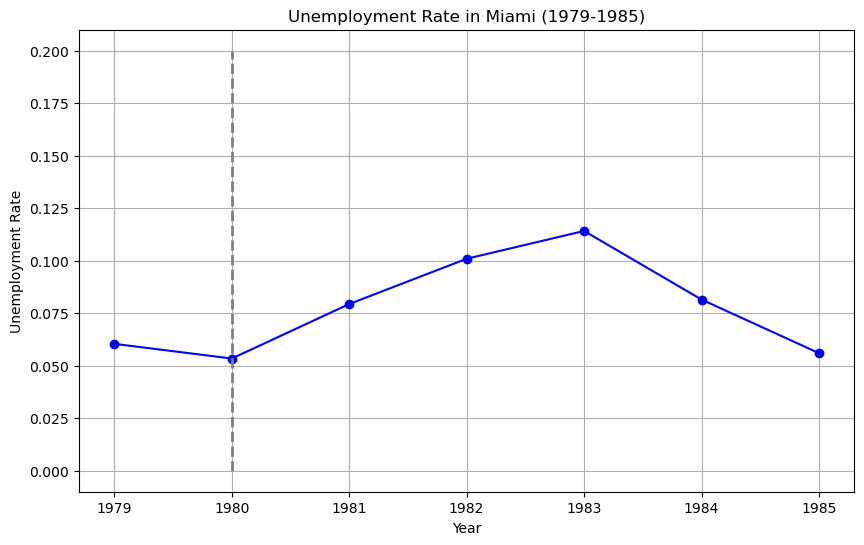

In [36]:
miami_ue_by_year = miami_ue.groupby('year')['esr'].agg(get_ue).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(miami_ue_by_year['year'], miami_ue_by_year['esr'], marker='o', color='b', linestyle='-')
plt.title('Unemployment Rate in Miami (1979-1985)')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.grid(True)
plt.vlines(1980, 0, 0.2, color="grey", linestyle="--", linewidth=2)  # Vertical line at 1980

plt.show()

In [37]:
grader.check("q2_1")

q2_1 results: All test cases passed!

Now we want to explore unemployment statistics by ethnicity. This can be accomplished by creating a pivot table. The `.pivot_table()` method can also take as an argument (`aggfunc`) an aggregator function which determines how to calculate the values in the output. In this case, it will take the array of `esr` values that correspond to each `year`-`ethrace` pair to the function we pass and apply the `get_ue` function on it. 

The end result is that we will have a table where each column is an `ethrace` value, each row is a year, and the values are the unemployment rate for that `ethrace` value. All of this is done for you in the cell below, and the results are stored as `miami_ue_ethrace`.

In [38]:
miami_ue_ethrace = pd.pivot_table(miami_ue, values='esr', index=['year'], columns=['ethrace'], aggfunc=get_ue)
miami_ue_ethrace

ethrace,blacks,cubans,hispanics,whites
year,,,,
1979,0.087121,0.053412,0.056075,0.049875
1980,0.050847,0.072386,0.079710,0.028061
1981,0.092937,0.102804,0.097345,0.041262
1982,0.163424,0.112500,0.088000,0.052897
1983,0.192308,0.131579,0.077419,0.071274
1984,0.144681,0.074935,0.123596,0.036446
1985,0.075188,0.055556,0.044444,0.050000


**Question 2.2:** Create the same pivot table below (include the same age restriction), but for the comparison cities (that is, all cities _except for Miami_). As we are looking at comparison cities, we must exclude Cubans from this pivot table. Store the pivot table as `not_miami_ue_ethrace`.

In [39]:
not_miami_ue = mariel[(mariel["smsarank"] != "Miami") & \
                  (mariel["ethrace"] != 'cubans') & \
                  (mariel["age"] >= 16) & \
                  (mariel["age"] <= 61)]
 # select relevant rows
not_miami_ue_ethrace = pd.pivot_table(not_miami_ue, values='esr', index=['year'], columns=['ethrace'], aggfunc=get_ue) # pivot table
not_miami_ue_ethrace


ethrace,blacks,hispanics,whites
year,,,
1979,0.107919,0.065920,0.045333
1980,0.135095,0.090656,0.045255
1981,0.125889,0.088068,0.043226
1982,0.125614,0.119714,0.069431
1983,0.182296,0.127942,0.070855
1984,0.124093,0.105373,0.055590
1985,0.128988,0.099552,0.051900


In [40]:
grader.check("q2_2")

q2_2 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 2.3:** Why did we drop the Cubans for comparison cities in question 2.2? Explain in the context of the study. 

When we are running regressions, we need to make sure to avoid the mistake of the dummy variable trap. We have to drop one group to be the base group, and in this case we use the Cubans as the base group. In other words, if all of these dummy variables are zero, then the default group would be Cubans. 

<!-- END QUESTION -->

In the cell below, we plot the unemployment rates for Miami and the comparison cities for each `ethrace` value. The dashed vertical line in 1980 indicates the Mariel boatlift's occurance. (The function `plot_ue_by_ethrace`, along with the other plotting functions in this notebook, are defined in the `utils.py` file if you want to look at them. They're hidden because the code is very verbose.)

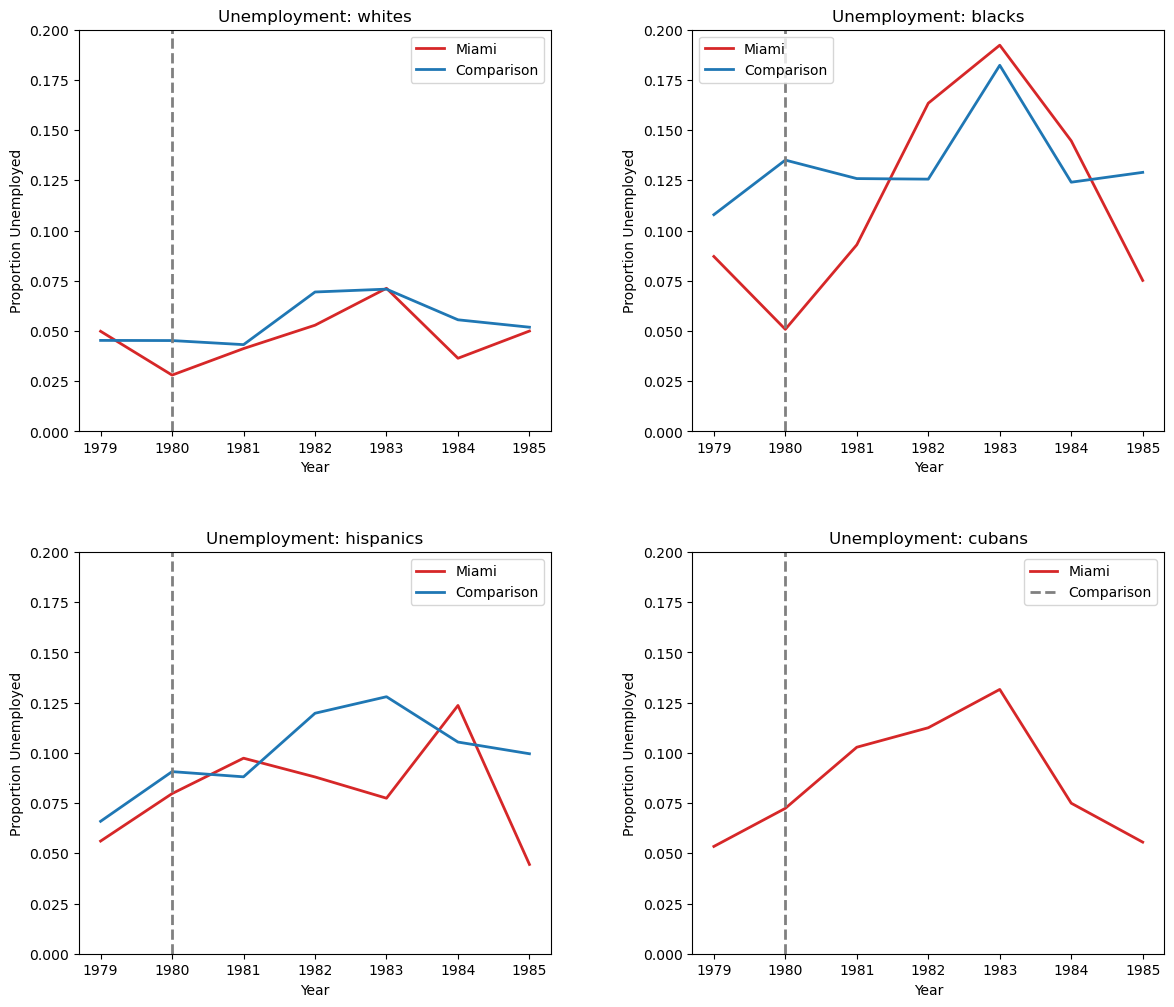

In [41]:
plot_ue_by_ethrace(miami_ue_ethrace, not_miami_ue_ethrace)

<!-- BEGIN QUESTION -->

**Question 2.4:** Unemployment after the Mariel boatlift goes up for all groups, rising from 5.0% in April 1980 to 7.1% in July. Why does Card argue that "there is no evidence that the Mariel influx adversely affected the unemployment rate of either whites or blacks" (p. 250)?

Card argues that there isn't evidence of the Mariel immigration negatively affecting whites and blacks because he talks about how in the comparison cities, whites and blacks faced similar economic outcomes in terms of unemployment. Additionally, Card points out that real earnings in Miami for whites were roughly the same as the real earnings for whites in other cities. On the other hand, the real wages for blacks in Miami stayed relatively constant, showing that there wasn't a reaction to the wages of blacks in Miami after the Mariel immigration. Card inputs this analysis to show how Miami is relatively similar to the comparison cities, making his cities chosen for comparison valid.

<!-- END QUESTION -->

**Question 2.5:** How much attention should we pay to the ups and downs in these graphs? Are these chance fluctuations from the sample survey ("noise"), or are they important information that we should pay attention to ("signal")?

1. The fluctuations doesn't seem arbitrary, so they are signal
2. The trend reverses very quickly and very suddenly, so they are just noises
3. We can’t tell just by looking, but one could in theory (and with the help of a statistics course) quantify the magnitude of fluctuations that we would expect from random sampling.

Assign the number corresponding to your answer to `q2_4` below.

In [98]:
q2_5 = 3

In [99]:
grader.check("q2_5")

q2_5 results: All test cases passed!

---
## Part 3: Wages

Now we will try to replicate Card's findings that the Mariel boatlift also had little or no effect on non-immigrants' wages. For simplicity, we will not deflate the wages (like we should) but we will instead consider the nominal wages.

As some of the values in the `earnhre` column are missing, for the sake of simplicity we remove these problematic rows below. Once again, this is not the best approach in real life and is only being done here for the sake of simplicity. **Throughout part 3, make sure you use `mariel_ehre` instead of `mariel`, or else your calculations may error.**

In [100]:
mariel_ehre = mariel[~np.isnan(mariel["earnhre"])].copy()

In order to make the wages more linear and to put them on an easier-to-understand scale, we take the natural log of each value in the `earnhre` column and store this as `log_w` (why do we divide by 100?).

In [101]:
log_w = np.log(mariel_ehre["earnhre"]/100)
mariel_ehre["log_w"] = log_w
mariel_ehre.head(5)

,age,smsarank,esr,ftpt79,earnhre,educ,ethrace,year,log_w
3,56,Los Angeles,Employed-At Work,Employed full-time,700.0,HS,whites,1979,1.945910
6,23,Los Angeles,Employed-At Work,Employed full-time,1002.0,HS,whites,1979,2.304583
16,65,Los Angeles,Employed-At Work,Employed full-time,895.0,HS,whites,1979,2.191654
32,61,Los Angeles,Employed-At Work,Employed PT,500.0,HS,whites,1979,1.609438
35,41,Los Angeles,Employed-At Work,Employed full-time,400.0,lessHS,whites,1979,1.386294


We want to create a similar pivot table as in part 2, except we want the values in this table to be the mean of the log of wages. We create this table for Miami below, making sure to also filter `merial_ehre` for rows where the individual is employed full-time.

In [102]:
miami_wages = mariel_ehre[(mariel_ehre["age"] >= 16) & \
                          (mariel_ehre["age"] <= 61) & \
                          (mariel_ehre["smsarank"] == "Miami") & \
                          (mariel_ehre["ftpt79"] == "Employed full-time")]
miami_wages_ethrace = pd.pivot_table(miami_wages, values="log_w", index=["year"], columns=["ethrace"], aggfunc=np.mean)
miami_wages_ethrace

ethrace,blacks,cubans,hispanics,whites
year,,,,
1979,1.433196,1.435591,1.342982,1.664646
1980,1.559940,1.455480,1.424821,1.740305
1981,1.719957,1.579118,1.550045,1.818311
1982,1.666419,1.606005,1.675179,1.879977
1983,1.678183,1.618799,1.638360,1.911506
1984,1.782611,1.687249,1.750424,1.924276
1985,1.860924,1.612961,1.808548,1.869408


**Question 3.1:** Create a similar pivot table below, except not including the cubans and using data from comparison cities (that is, all cities _except for Miami_). Store the pivot table as `not_miami_wages_ethrace`.

In [103]:
not_miami_wages = mariel_ehre[(mariel_ehre["age"] >= 16) & \
                          (mariel_ehre["age"] <= 61) & \
                          (mariel_ehre["smsarank"] != "Miami") & \
                          (mariel_ehre["ethrace"] != "cubans") & \
                          (mariel_ehre["ftpt79"] == "Employed full-time")] # select relevant rows
not_miami_wages_ethrace = pd.pivot_table(not_miami_wages, values="log_w", index=["year"], columns=["ethrace"], aggfunc=np.mean) # pivot table
not_miami_wages_ethrace

ethrace,blacks,hispanics,whites
year,,,
1979,1.590354,1.528109,1.723509
1980,1.695692,1.612716,1.815481
1981,1.763279,1.705438,1.891075
1982,1.857684,1.742029,1.965920
1983,1.893868,1.771680,1.975914
1984,1.883949,1.826412,2.010343
1985,1.892658,1.831231,2.062001


In [104]:
grader.check("q3_1")

q3_1 results: All test cases passed!

In the cell below, we plot the wages for Miami and the comparison cities for each `ethrace` value.

In [42]:
plot_wages_by_ethrace(miami_wages_ethrace, not_miami_wages_ethrace)

NameError: name 'miami_wages_ethrace' is not defined

Our numbers differ from Card's Table 4 because we are not accounting for inflation. In order to make inferences about the effect of the boatlift on wages easier, let's plot the differences between Miami and the Comparison Cities. (The difference being plotted here is log wages for Miami *minus* log wages for comparison cities)

In [43]:
plot_wage_diffs_by_ethrace(miami_wages_ethrace, not_miami_wages_ethrace)

NameError: name 'miami_wages_ethrace' is not defined

**Question 3.2:** If wages were hurt by the influx of migrants, we would expect this graph to show

1. A decrease after 1980, as Miami wages went down relative to other cities
2. Values below 0 for all periods, because Miami would always have lower wages
3. An uptick after 1980, because we are working with logarithms.
4. An increase after 1980, as Miami wages went down relative to other cities

Assign the number corresponding to your answer to `q3_2` below.

_Hint:_ $\log A  - \log B = \log \frac{A}{B}$

In [107]:
q3_2 = 1

In [108]:
grader.check("q3_2")

q3_2 results: All test cases passed!

So it seems that indeed our analysis is consistent with Card's conclusion that "the Mariel immigration had virtually no effect on wages or unemployment outcomes of non-Cuban workers in the Miami labor market" (p. 255).

---
## Part 4: Education

We would expect any negative effect of the influx of immigrants to be strongest on the group that they most resemble. Because most of the Cuban immigrants in the boatlift were unskilled, we would expect the strongest effect on non-immigrants with the least education, with perhaps the clearest comparison group being Hispanics with the least education.

Card used a different approach, looking at the effects for low-skilled workers by predicting wages based on education and years of experience. Here we do something a bit simpler, using education only.

<!-- BEGIN QUESTION -->

**Question 4.1:** If the boatlift had a negative effect on the employment of unskilled workers, what would we expect to see in the unemployment for each of categories of education in both Miami and the comparison cities? 

_Note:_ The possible values of `educ` are `BA`, `HS`, or `lessHS`.

If the boatlift had a negative effect on the employment of unskilled workers, the earnings per hour would show a decrease in education that is less than high school. lessHS would probably become more negative, for Miami. The comparison cities shouldn't have a change in their educ values since they are not receiving immigrants. For the Miami model, the educ values for BA and HS would stay relatively the same. This is true for the comparison cities model.

<!-- END QUESTION -->

We want to create a similar pivot table as in parts 2 and 3, except we want the values in this table to be the mean of the unemployment rate partitioned by _education_, not `ethrace`. We create this table for Miami below.

In [109]:
miami_educ_ue = mariel[(mariel["age"] >= 16) & \
                       (mariel["age"] <= 61) & \
                       (mariel["smsarank"] == "Miami")]
miami_educ_ue = pd.pivot_table(miami_educ_ue, values="esr", index=["year"], 
                               columns=["educ"], aggfunc=get_ue)
miami_educ_ue

educ,BA,HS,lessHS
year,,,
1979,0.036842,0.048986,0.094801
1980,0.038674,0.038580,0.086721
1981,0.027027,0.067278,0.125326
1982,0.031915,0.083601,0.165312
1983,0.026432,0.107829,0.180328
1984,0.024096,0.080960,0.126935
1985,0.013986,0.063063,0.077844


<!-- BEGIN QUESTION -->

**Question 4.2:** What happens to the unemployment rates of those with a college education (BA) between 1980 and 1982, when the effects of the Mariel boatlift should have been felt? What happens to those with the least education? ("lessHS"). Is this consistent with a large effect of immigration on the least educated that is hypothesized above?

The unemployment rates of those with a college education between 1980 and 1982 would stay around the same since the Mariel boatlift is more strongly affecting the people with the least amount of education. The unemployment rates for those with the least education would probably rise, as there is more competition for jobs since there is an influx in the labor supply. This is consistent with the large effect of immigration on the least educated because that is the population of people that is most impacted by an influx in more unskilled laborers.

<!-- END QUESTION -->

**Question 4.3:** Create the same pivot table below, except for the comparison cities (that is, all cities _except for Miami_). Store the pivot table as `not_miami_educ_ue`.

In [110]:
not_miami_educ_ue = mariel[(mariel["age"] >= 16) & \
                       (mariel["age"] <= 61) & \
                       (mariel["smsarank"] != "Miami")] # select relevant rows
not_miami_educ_ue = pd.pivot_table(not_miami_educ_ue, values="esr", index=["year"], \
                               columns=["educ"], aggfunc=get_ue) # pivot table
not_miami_educ_ue


educ,BA,HS,lessHS
year,,,
1979,0.037037,0.050183,0.091659
1980,0.030181,0.059263,0.115025
1981,0.028841,0.055288,0.116598
1982,0.041056,0.079636,0.150665
1983,0.040887,0.087858,0.179265
1984,0.040208,0.070013,0.130964
1985,0.036661,0.065138,0.133809


In [111]:
grader.check("q4_3")

q4_3 results: All test cases passed!

In the cell below, we plot the unemployment rates for Miami and the comparison cities for each `educ` value.

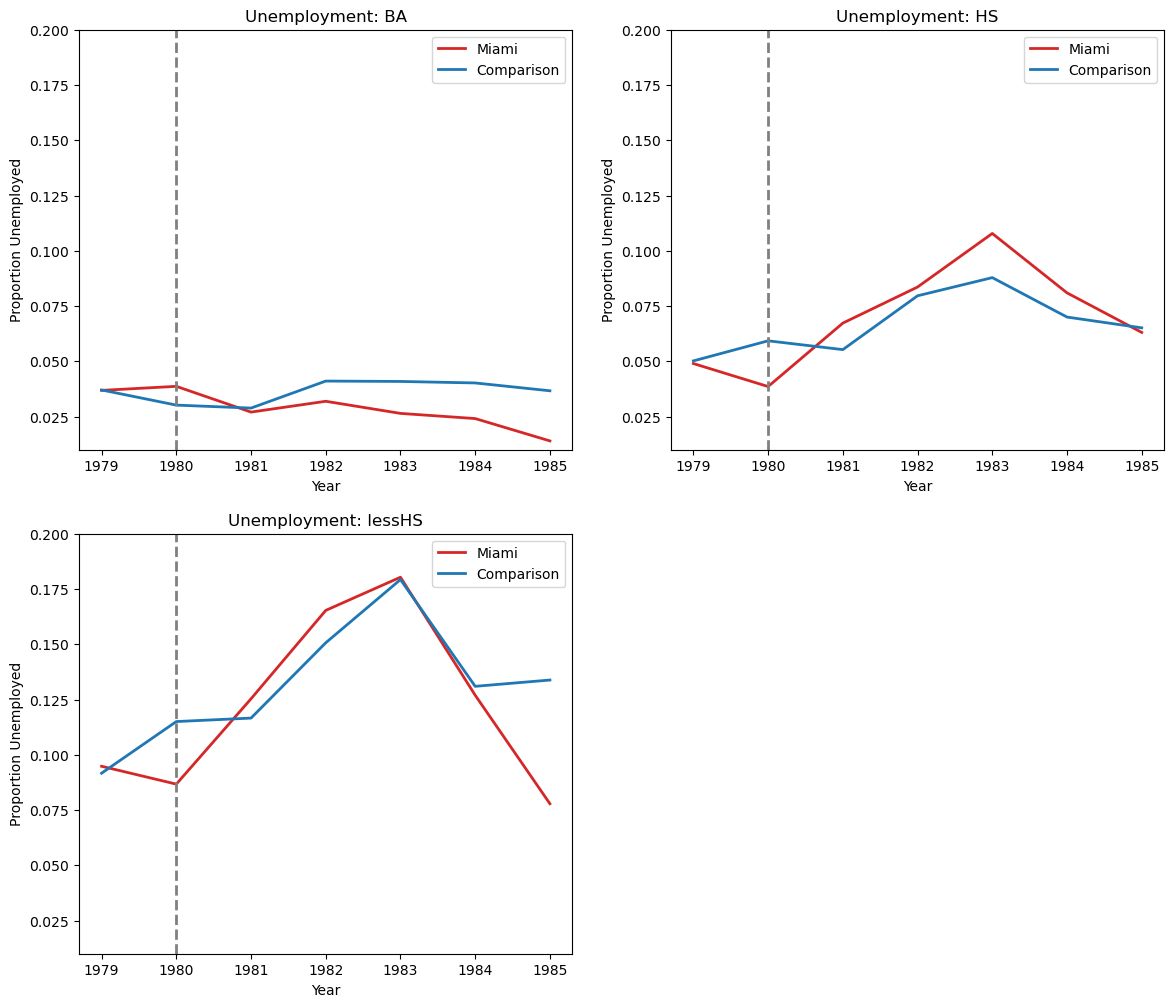

In [112]:
plot_ue_by_educ(miami_educ_ue, not_miami_educ_ue)

<!-- BEGIN QUESTION -->

**Question 4.4:** Like Card's study, many empirical papers find very small or no impact of immigration on local workers' wages and employment. Several studies even found a positive impact of skilled immigration on wages and employment. What are 2 possible reasons why having immigrants could benefit non-immigrant workers?

Two reasons immigrants could have a benefit on native workers is that higher skilled immigrants can drive an increase in competition for jobs. As the skills of laborers increase, this can drive the competition for jobs, making wages also competitive. Another reason skilled immigrants could have a positive impact on non immigrant workers is employing more skilled workers in general can increase the productivity of a firm, which benefits its own employees because a company that performs better will probably have more resources to help their employees.

<!-- END QUESTION -->

---
## Part 5: What Determines Wages?
Now we want to use the data and expand on the above analysis by asking what variables are related to wages. We will use the basic OLS regression to quantitatively determine the association. This is also part of the analysis Card used to produce Table 7 in his paper. 

**Question 5.1:** Filter `mariel_ehre` for individuals that are being employed full-time. Assign the result to `mariel_full_time`. 

In [113]:
mariel_full_time = mariel_ehre[mariel_ehre['ftpt79'] == 'Employed full-time']
mariel_full_time


,age,smsarank,esr,ftpt79,earnhre,educ,ethrace,year,log_w
3,56,Los Angeles,Employed-At Work,Employed full-time,700.0,HS,whites,1979,1.945910
6,23,Los Angeles,Employed-At Work,Employed full-time,1002.0,HS,whites,1979,2.304583
16,65,Los Angeles,Employed-At Work,Employed full-time,895.0,HS,whites,1979,2.191654
35,41,Los Angeles,Employed-At Work,Employed full-time,400.0,lessHS,whites,1979,1.386294
39,53,Los Angeles,Employed-At Work,Employed full-time,700.0,lessHS,whites,1979,1.945910
...,...,...,...,...,...,...,...,...,...
121469,33,Atlanta,Employed-At Work,Employed full-time,500.0,HS,whites,1985,1.609438
121470,41,Atlanta,Employed-At Work,Employed full-time,1100.0,lessHS,whites,1985,2.397895
121471,36,Atlanta,Employed-At Work,Employed full-time,650.0,HS,whites,1985,1.871802
121472,25,Atlanta,Employed-At Work,Employed full-time,775.0,HS,whites,1985,2.047693


In [114]:
grader.check("q5_1")

q5_1 results: All test cases passed!

What variables in our dataframe are related to wages? It seems like `educ`, `ethrace`, `year`, and `smsarank` can have an influence on individuals' income. 

But note that these columns are strings, and we cannot run regression on string-values columns. To get around this, we will create some dummy variables (this process is often called "one-hot encoding"). 

For example, let's create some dummies for `educ` using `pd.get_dummies`. 

In [115]:
educ_dummies = pd.get_dummies(mariel_full_time["educ"], dtype=float)
educ_dummies

,BA,HS,lessHS
3,0.0,1.0,0.0
6,0.0,1.0,0.0
16,0.0,1.0,0.0
35,0.0,0.0,1.0
39,0.0,0.0,1.0
...,...,...,...
121469,0.0,1.0,0.0
121470,0.0,0.0,1.0
121471,0.0,1.0,0.0
121472,0.0,1.0,0.0


And we can add them back to a dataframe using `join`. But note that we should not include all the dummy columns, otherwise we will run into issues with linear dependence. This is called the "dummy variable trap". 

In [116]:
# Let's do everything all at once
mariel_regression = mariel_full_time.copy() # copy the dataframe
educ_dummies = pd.get_dummies(mariel_full_time["educ"], dtype=float) # create dummies for educ
educ_dummies = educ_dummies.iloc[:, :-1] # exclude the last column
mariel_regression = mariel_regression.join(educ_dummies) # add the dummy vars to dataframe
mariel_regression = mariel_regression.drop(["educ"], axis=1) # drop the original column
mariel_regression

,age,smsarank,esr,ftpt79,earnhre,ethrace,year,log_w,BA,HS
3,56,Los Angeles,Employed-At Work,Employed full-time,700.0,whites,1979,1.945910,0.0,1.0
6,23,Los Angeles,Employed-At Work,Employed full-time,1002.0,whites,1979,2.304583,0.0,1.0
16,65,Los Angeles,Employed-At Work,Employed full-time,895.0,whites,1979,2.191654,0.0,1.0
35,41,Los Angeles,Employed-At Work,Employed full-time,400.0,whites,1979,1.386294,0.0,0.0
39,53,Los Angeles,Employed-At Work,Employed full-time,700.0,whites,1979,1.945910,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
121469,33,Atlanta,Employed-At Work,Employed full-time,500.0,whites,1985,1.609438,0.0,1.0
121470,41,Atlanta,Employed-At Work,Employed full-time,1100.0,whites,1985,2.397895,0.0,0.0
121471,36,Atlanta,Employed-At Work,Employed full-time,650.0,whites,1985,1.871802,0.0,1.0
121472,25,Atlanta,Employed-At Work,Employed full-time,775.0,whites,1985,2.047693,0.0,1.0


#### How to interpret the dummy variables for education?

We notice that there are two dummy variable columns for education: `BA` and `HS`. When `BA` is 1, it means the individual in this row has a Bachelor's degree. When `HS` is 1, it means the individual in this row has a high school degree (but not a Bachelor's degree). When both `BA` and `HS` are 0, that implies `lessHS` should be 1, and it means the individual in this row has less education than a high school degree. 

Therefore when `BA` and `HS` show up in a regression, we can interpret their coefficients as the following:
- Coefficient for `BA`: the average amount of wages an individual with a Bachelor's degree earns *minus* the average amount of wages an individual with less than a high school degree earns. In other words, if the coefficient is 1, then we can say that on average an individual with a Bachelor's degree earns 1 unit (what's the unit?) more than an individual with less than a high school degree. 
- Coefficient for `HS`: the average amount of wages an individual with a high school degree earns *minus* the average amount of wages an individual with less than a high school degree earns. 

So in short, the coefficients for education (`BA` and `HS`) represent the additional wages earned compared to the base case scenario (which is the column that we excluded, and in this case `lessHS`). Let's try running the regression.

In [117]:
X = mariel_regression.iloc[:, -2:] # BA and HS
X = sm.add_constant(X) # add a constant term
y = mariel_regression["earnhre"]
model_1 = sm.OLS(y, X).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                earnhre   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     765.6
Date:                Fri, 15 Mar 2024   Prob (F-statistic):          4.94e-324
Time:                        00:05:06   Log-Likelihood:            -1.9399e+05
No. Observations:               26424   AIC:                         3.880e+05
Df Residuals:                   26421   BIC:                         3.880e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        575.3880      4.102    140.264      0.000     567.348     583.429
BA           329.9094      9.190     35.898      0.000     311.896     347.922
HS           139.0138      5.049     27.531      0.000     129.117     148.911
==============================================================================
Omnibus:                    29813.832   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9794441.328
Skew:                           5.384   Prob(JB):                         0.00
Kurtosis:                      96.702   Cond. No.                         5.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
# sanity check: 
# the coefficient for constant should be 575.3880
assert np.isclose(model_1.params["const"], 575.3880)

**What is the interpretation of this regression result?**

The results show that on average individuals with less than high school degree education earns 575.39 (unit omitted; you should include it!); on average individuals with high school degree earns 714.4018 (575.3880 + 139.0138); and finally individuals with Bachelor's degree earns 905.2974 (575.3880 + 329.9094) on average. And the result is highly significant given the t-stat and p-values. So in our data, education plays an important role in determining wages. 

Now we will add the remaining variables `ethrace`, `year`, and `smsarank` to our regression. First, generate dummy variables for all of them. Let's start afresh! 

**Question 5.2:** Generate dummy variables for `educ`, `ethrace`, `year`, and `smsarank`. Add those dummy variables to `mariel_regression` and then drop the original column. Be sure to exclude the last dummies for each variable to avoid the 'dummy variable trap'!

In [119]:
mariel_regression = mariel_full_time.copy()

mariel_regression = mariel_full_time.copy() # copy the dataframe
educ_dummies = pd.get_dummies(mariel_full_time["educ"], dtype=float) # create dummies for educ
educ_dummies = educ_dummies.iloc[:, :-1] # exclude the last column
mariel_regression = mariel_regression.join(educ_dummies) # add the dummy vars to dataframe
mariel_regression = mariel_regression.drop(["educ"], axis=1) # drop the original column

ethrace_dummies = pd.get_dummies(mariel_full_time["ethrace"], dtype=float) # create dummies for educ
ethrace_dummies = ethrace_dummies.iloc[:, :-1] # exclude the last column
mariel_regression = mariel_regression.join(ethrace_dummies) # add the dummy vars to dataframe
mariel_regression = mariel_regression.drop(["ethrace"], axis=1)

year_dummies = pd.get_dummies(mariel_full_time["year"], dtype=float) # create dummies for educ
year_dummies = year_dummies.iloc[:, :-1] # exclude the last column
mariel_regression = mariel_regression.join(year_dummies) # add the dummy vars to dataframe
mariel_regression = mariel_regression.drop(["year"], axis=1)

smsarank_dummies = pd.get_dummies(mariel_full_time["smsarank"], dtype=float) # create dummies for educ
smsarank_dummies = smsarank_dummies.iloc[:, :-1] # exclude the last column
mariel_regression = mariel_regression.join(smsarank_dummies) # add the dummy vars to dataframe
mariel_regression = mariel_regression.drop(["smsarank"], axis=1)

mariel_regression

,age,esr,ftpt79,earnhre,log_w,BA,HS,blacks,cubans,hispanics,1979,1980,1981,1982,1983,1984,Atlanta,Houston,Los Angeles,Miami
3,56,Employed-At Work,Employed full-time,700.0,1.945910,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,23,Employed-At Work,Employed full-time,1002.0,2.304583,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16,65,Employed-At Work,Employed full-time,895.0,2.191654,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
35,41,Employed-At Work,Employed full-time,400.0,1.386294,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39,53,Employed-At Work,Employed full-time,700.0,1.945910,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121469,33,Employed-At Work,Employed full-time,500.0,1.609438,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
121470,41,Employed-At Work,Employed full-time,1100.0,2.397895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
121471,36,Employed-At Work,Employed full-time,650.0,1.871802,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
121472,25,Employed-At Work,Employed full-time,775.0,2.047693,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [120]:
grader.check("q5_2")

q5_2 results: All test cases passed!

Great job! Now we have our dataframe is ready for regression!

First, let's run an OLS regression using only `educ` and `ethrace`, so that we can get a sense of how these two variables influenced wages (use `earnhre` for now) during the sample period. 

**Question 5.3:** Run a regression with `earnhre` as the explained variable (y) and the dummies for `educ` and `ethrace` as the explanatory variables (X). Include a constant term in your regression. Assign your OLS model to `model_2`. 

In [121]:
X = mariel_regression[['BA', 'HS', 'blacks','cubans','hispanics']]
X = sm.add_constant(X)
y = mariel_regression["earnhre"]
model_2 = sm.OLS(y, X).fit()
model_2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                earnhre   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     416.7
Date:                Fri, 15 Mar 2024   Prob (F-statistic):               0.00
Time:                        00:05:10   Log-Likelihood:            -1.9373e+05
No. Observations:               26424   AIC:                         3.875e+05
Df Residuals:                   26418   BIC:                         3.875e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        644.0090      5.322    121.002      0.000     633.577     654.441
BA           291.1217      9.395     30.986      0.000     272.706     309.537
HS           109.9968      5.342     20.590      0.000      99.525     120.468
blacks       -99.5198      6.243    -15.940      0.000    -111.757     -87.283
cubans      -183.1562     11.081    -16.529      0.000    -204.876    -161.437
hispanics    -86.1181      5.923    -14.539      0.000     -97.728     -74.508
==============================================================================
Omnibus:                    30056.983   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10386647.276
Skew:                           5.449   Prob(JB):                         0.00
Kurtosis:                      99.515   Cond. No.                         6.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [122]:
grader.check("q5_3")

q5_3 results: All test cases passed!

**Question 5.4:** According to the regression output, how much **more** on average does a Cuban individual with a high school degree earn than another Cuban individual with less than a high school education? Assign the number corresponding to your answer to `q5_4` below. Make sure you assign the exact number rather than an estimate.

In [123]:
q5_4 = 109.9968
q5_4

109.9968

In [124]:
grader.check("q5_4")

q5_4 results: All test cases passed!

**Question 5.5:** According to the regression output, how much **more** on average does a Cuban individual with a high school degree earn than another white individual with a high school degree? If you think the Cuban individual earns less, put a negative number. Assign the number corresponding to your answer to `q5_5` below. Again, make sure you assign the exact number rather than an estimate.

In [125]:
q5_5 = -183.1562
q5_5

-183.1562

In [126]:
grader.check("q5_5")

q5_5 results: All test cases passed!

**Question 5.6:** According to the regression output, how much does a Cuban individual with a high school degree earn on average? Assign the number corresponding to your answer to `q5_6` below. Again, make sure you calculate and assign the exact number rather than an estimate.

In [127]:
q5_6 = 570.8496

In [128]:
grader.check("q5_6")

q5_6 results: All test cases passed!

Now, let's run an OLS regression using all the variables that we have. 

**Question 5.7:** Run a regression with `earnhre` as the explained variable (y) and the dummies for `educ`, `ethrace`, `year` and `smsarank` as the explanatory variables (X). Include a constant term in your regression. Assign your OLS model to `model_3`. 

In [129]:
X = mariel_regression[['BA', 'HS', 'blacks', 'cubans', 'hispanics', 1979, 1980, 1981, 1982, 1983, 1984
                       , 'Atlanta', 'Houston', 'Los Angeles', 'Miami']]
X = sm.add_constant(X)
y = mariel_regression["earnhre"]
model_3 = sm.OLS(y, X).fit()
model_3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                earnhre   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     268.7
Date:                Fri, 15 Mar 2024   Prob (F-statistic):               0.00
Time:                        00:05:17   Log-Likelihood:            -1.9286e+05
No. Observations:               26424   AIC:                         3.857e+05
Df Residuals:                   26408   BIC:                         3.859e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         600.6579     11.132     53.959      0.000     578.839     622.477
BA            269.5419      9.117     29.564      0.000     251.671     287.412
HS             99.8565      5.187     19.252      0.000      89.690     110.023
blacks        -93.9887      6.146    -15.292      0.000    -106.036     -81.942
cubans       -137.6395     12.559    -10.959      0.000    -162.256    -113.023
hispanics    -131.9317      6.000    -21.987      0.000    -143.693    -120.171
1979         -210.7470      9.377    -22.476      0.000    -229.126    -192.368
1980         -162.1437      9.359    -17.324      0.000    -180.489    -143.799
1981         -107.6637      9.401    -11.452      0.000    -126.091     -89.237
1982          -55.8124      9.534     -5.854      0.000     -74.499     -37.126
1983          -44.2020      9.534     -4.636      0.000     -62.889     -25.515
1984          -14.4158      9.405     -1.533      0.125     -32.851       4.019
Atlanta        90.2081     10.121      8.913      0.000      70.371     110.046
Houston       191.8446      8.853     21.671      0.000     174.493     209.196
Los Angeles   192.4943      8.063     23.875      0.000     176.691     208.297
Miami          87.1905     10.594      8.231      0.000      66.427     107.954
==============================================================================
Omnibus:                    31507.616   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13674477.777
Skew:                           5.878   Prob(JB):                         0.00
Kurtosis:                     113.823   Cond. No.                         13.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [130]:
grader.check("q5_7")

q5_7 results: All test cases passed!

**Question 5.8:** According to the regression output, does the nominal wage (`earnhre`) increase over time in the sample period? Assign the either `True` or `False` to `q5_8` below.

In [131]:
q5_8 = True

In [132]:
grader.check("q5_8")

q5_8 results: All test cases passed!

**Question 5.9:** According to the regression output, which city in the data had the lowest wages on average assume all other variables equal? Assign the `smsarank` of that city to `q5_9` below.

In [133]:
q5_9 = 'Miami'

In [134]:
grader.check("q5_9")

q5_9 results: All test cases passed!

## Conclusions

In this project, we saw that the Mariel boatlift had little effect on unemployment among ethnic groups in Miami, as the cities that were not receiving \(many\) immigrants were afflicted by the same trends in unemployment. We also saw that the same is true of education-level groups. In fact, many studies find that influxes of immigrants benefit the native-born workers in a region; that they act as complements rather than supplements to the native workforce.

**Congratulations!** You're done with Project 2!

---
## Feedback

**Question 6:** Please fill out this short [feedback form](https://forms.gle/MFUgdGZyXhrZcWwj9) to let us know your thoughts about this lab! We really appreciate your opinions and feedback! At the end of the Google form, you should see a codeword. Assign the codeword to the variable `codeword` below. 

In [135]:
codeword = "boatlift"

In [136]:
grader.check("q6")

q6 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [137]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1_1 results: All test cases passed!

    q1_2 results: All test cases passed!

    q1_3 results: All test cases passed!

    q1_4 results: All test cases passed!

    q1_5 results: All test cases passed!

    q2_1 results: All test cases passed!

    q2_2 results: All test cases passed!

    q2_5 results: All test cases passed!

    q3_1 results: All test cases passed!

    q3_2 results: All test cases passed!

    q4_3 results: All test cases passed!

    q5_1 results: All test cases passed!

    q5_2 results: All test cases passed!

    q5_3 results: All test cases passed!

    q5_4 results: All test cases passed!

    q5_5 results: All test cases passed!

    q5_6 results: All test cases passed!

    q5_7 results: All test cases passed!

    q5_8 results: All test cases passed!

    q5_9 results: All test cases passed!

    q6 results: All